# Lab 4 - Detecting and Mitiating Bias in Machine Learning
Week 4 - PM034A Machine learning for socio-technical systems <br>

By <b> Nadia Metoui* </b> <br>
Faculty of Technology, Policy, and Management (TPM)<br>

<small>*Acknowledgement: Part of this lab is loosely based on the code developed by <i><b>Agathe Balayn</b></i> and <i><b>Seda Gürses</b></i>

***Learning Objectives***<br>
Examine the impact of ML-based solutions and interventions on individuals, organisations, and society.<br>
Apply ML <b>Operational Fairness tools</b> in real-world socio-technical examples.

<H2> </H2>

# Part I. Pre-processing.

In this part of the assignment, you will be exploring a use case where a Bank wants to develop an ML-based ADM (automate decision system) to decide whether to <b>grant</b> or <b>not to grant</b> a loan to a given applicant. To do so the Bank uses historical data containing multiple application records, characterized by information about the loan applicants (e.g., age, gender, personal situation) and information about the loan (e.g., amount, duration, purpose). Each application is labeled <i><b> good credit </b></i> if the loan had been reimbursed or <i><b>bad credit</b></i> if the loan has not been reimbursed or if there where several issues with the reimbursement.

To simulate this scenario we will build a classifier to disinguich between good and bad loans (or credits). We will train the classifier using the <i><b>German credit data</b></i> (you can information about the dataset and its attributes here: (https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc).<br>
And you can download the dataset here:
https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data<br>


- Step 1: Set-up (Provided)
- Step 2: Explore and familiarize with the dataset
- Step 3: Protected attributes, proxies, 
- Step 4: Representation Bias, Disparities and Skews.


<H3>Setp 1: Set-up</H3>

You first need to install the required libraries for this part.  The main libraries are the `aif360` and `sklearn` ones. We also recommend using `numpy` or `pandas` to easily manipulate and explore the data.

<div class="alert alert-block alert-danger">
<b>Note:</b> Uncomment and run the next cell if you have not previously installed the libraries.
</div>


<b>Installing required libraries</b>

In [1]:
# #uncomment if you need to install the libraries
# !pip install aif360
# !pip install fairlearn



<b>Loading required libraries</b>

In [2]:
# Libraries for data processing and visualiztion 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown, display

#ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline

np.random.seed(0)

# Faireness Tool IBM AI Fairness 360
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.inprocessing import MetaFairClassifier


pip install 'aif360[LawSchoolGPA]'


<b>Download the German Credit Data set</b><br>
In the following we will download the data set and https://archive.ics.uci.edu its documentation from the website and place it in the correct folder to be accessed by aif360.

**Option 1 Google Colab:**<br>
Uncomment the following cell to download the dataset in google colab.

In [3]:
#Download the German Credit DataSet
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
!cp german.data /usr/local/lib/python3.8/dist-packages/aif360/data/raw/german/german.data
!cp german.doc /usr/local/lib/python3.8/dist-packages/aif360/data/raw/german/german.doc

--2022-12-07 16:16:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.8’

german.data.8       100%[===================>]  77.92K  --.-KB/s    in 0.1s    

2022-12-07 16:16:37 (765 KB/s) - ‘german.data.8’ saved [79793/79793]

--2022-12-07 16:16:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc.8’

german.doc.8        100%[===================>]   4.57K  --.-KB/s    i

**Option 2: Local environment**<br>
<div class="alert alert-block alert-danger">
<b>Note:</b> If you are working on your local environment you will have to manually add the files "german.doc" and "german.data" to the folder 
"dist-packages/aif360/data/raw/german/" under your python path.<br>
You can find the files in the lab folder on github or download them from: <br>
<a href="https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data">https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data</a> <br>
<a href="https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc">https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc</a>
</div> 

<b>Loading the dataset</b>

Here, we will load the <i><b>German credit data</b></i> in a format that is compatible with the use of the <i><b>AIF360 toolkit</b></i>. For this, you need to make use of the already implemented class of the toolkit `GermanDataset()`.

Because the data available is encoded in a complex way, we provide you with the code to preprocess it, in the function `custom_preprocessing()`. We also provide you with an example on how to actually load the data using the `GermanDataset()` class, in `preproc_and_load_data_german()`. 

In [4]:
def preproc_and_load_data_german():
    """
    Load and pre-process german credit dataset.
    Args: -
    Returns:
        GermanDataset: An instance of GermanDataset with required pre-processing.
    """
    def custom_preprocessing(df):
        """ Custom pre-processing for German Credit Data
        """

        def group_credit_hist(x):
            if x in ['A30', 'A31', 'A32']:
                return 'None/Paid'
            elif x == 'A33':
                return 'Delay'
            elif x == 'A34':
                return 'Other'
            else:
                return 'NA'

        def group_employ(x):
            if x == 'A71':
                return 'Unemployed'
            elif x in ['A72', 'A73']:
                return '1-4 years'
            elif x in ['A74', 'A75']:
                return '4+ years'
            else:
                return 'NA'

        def group_savings(x):
            if x in ['A61', 'A62']:
                return '<500'
            elif x in ['A63', 'A64']:
                return '500+'
            elif x == 'A65':
                return 'Unknown/None'
            else:
                return 'NA'

        def group_status(x):
            if x in ['A11', 'A12']:
                return '<200'
            elif x in ['A13']:
                return '200+'
            elif x == 'A14':
                return 'None'
            else:
                return 'NA'
        
        def group_personal_status(x):
            if x in ['A91']:
                return 'divorced/separated'
            elif x in ['A92']:
                return 'divorced/separated/married'
            elif x in ['A93', 'A95']:
                return 'single'
            elif x in ['A94']:
                return 'married/widowed'
            else:
                return 'NA'

        def group_foreign_worker(x):
            if x in ['A201']:
                return 'yes'
            elif x in ['A202']:
                return 'no'
            else:
                return 'NA'

        #print(df)
        #print(df.shape)
        #print(df.isnull().sum().sum())
        #print(df.isin(['NA']).sum(axis=0))
        status_map = {'A91': 1.0, 'A93': 1.0, 'A94': 1.0,
                    'A92': 0.0, 'A95': 0.0}
        
        df['sex'] = df['personal_status'].replace(status_map)
        

        # group credit history, savings, and employment
        df['credit_history'] = df['credit_history'].apply(lambda x: group_credit_hist(x))
        df['savings'] = df['savings'].apply(lambda x: group_savings(x))
        df['employment'] = df['employment'].apply(lambda x: group_employ(x))
        #df['age'] = df['age'].apply(lambda x: np.float(x >= 26))
        df['status'] = df['status'].apply(lambda x: group_status(x))
        df['personal_status'] = df['personal_status'].apply(lambda x: group_personal_status(x))
        df['foreign_worker'] = df['foreign_worker'].apply(lambda x: group_foreign_worker(x))
        group_foreign_worker
        #print(df.isin(['NA']).sum(axis=0))
        
        # print(df)
        # uncomment if you want to save a version of the processed data
        #df.to_csv("german_credit_data_processed.csv")
        return df

    # Feature partitions
    XD_features = ['number_of_credits', 'telephone',
                     'foreign_worker', 'people_liable_for', 'skill_level', 'credit_history', 'installment_plans', 'residence_since', 'property', 'other_debtors', 'purpose', 'savings', 'employment', 'sex', 'age', 'personal_status', 'month']
    D_features = ['sex', 'age'] 
    Y_features = ['credit']
    X_features = list(set(XD_features)-set(D_features))
    categorical_features = ['installment_plans', 'telephone',
                     'foreign_worker', 'skill_level', 'credit_history', 'property', 
                            'other_debtors', 'purpose', 'savings', 'employment', 'personal_status']

    # privileged classes
    all_privileged_classes = {"sex": [1.0],
                              "age": lambda x: x > 25}

    # protected attribute maps
    all_protected_attribute_maps = {"sex": {1.0: 'Male', 0.0: 'Female'},
                                    "age": {1.0: 'Old', 0.0: 'Young'}}

    return GermanDataset(
        label_name=Y_features[0],
        favorable_classes=[1],
        protected_attribute_names=D_features,
        privileged_classes=[all_privileged_classes[x] for x in D_features],
        instance_weights_name=None,
        categorical_features=categorical_features,
        features_to_keep=X_features+Y_features+D_features,
        features_to_drop=[],
        metadata={ 'label_maps': [{1.0: 'Good Credit', 2.0: 'Bad Credit'}],
                   'protected_attribute_maps': [all_protected_attribute_maps[x]
                                for x in D_features]},
        custom_preprocessing=custom_preprocessing)

<br><br>

<H3>Step 2: Explore and familiarize with the dataset</H3>

<b>Q1: Analyse the dataset and answer the following:</b> 
- What is the number of records?
- What is the number of attributes present with the preprocessing we provided? 
- What is the list of attribute names?
- Are there missing values that could create biases?

In [5]:
# Instanciating the German credit dataset
dataset_gcredit = preproc_and_load_data_german()

<div class="alert alert-block alert-info">
<b>Tip:</b> The documentation of "AIF360 - German credit data" dataset  can be found <a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.GermanDataset.html">[HERE]</a>. </div> 


Take a look at documentation of AIF360 and use existing methods to explore the dataset instance how to access the features with:<br> `dataset_gcredit.features`. 

You are also free to transform the dataset into a pandas dataframe to extract the needed information.
Use <br>
    `pd_gdata = pd.DataFrame(dataset_gcredit.features, columns=dataset_gcredit.feature_names)` <br>
    to create the pandas dataframe
</div> 

- 

In [6]:
### Some possible explorations ###
# Number of records:

# Number of features:

# Feature names:

# Number of missing values for each attribute ...

<div class="alert alert-block alert-success">
<b>Correct Answer:</b>
</div>

In [7]:
# Number of records:
print("Number of records: ",  dataset_gcredit.features.shape[0])
# Number of features:

print("Number of features: ",  dataset_gcredit.features.shape[1])
print('Number of attributes: 20 (7 numerical, 13 categorical)')

# Feature names:
print("Names of features: ",  dataset_gcredit.feature_names)

# Create a pandas dataframe. NB this dataframe has only the featuers
pd_gdata = pd.DataFrame(dataset_gcredit.features, columns=dataset_gcredit.feature_names)

# Are there missing values that could create biases
# print(pd_gdata.isin(['NA']).sum(axis=0))
print("Number of missing values for each attribute: ", pd_gdata.isnull().sum())


# Number of records:  1000
# Number of features:  47
# Names of features:  ['month', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 
# 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'purpose=A40', 'purpose=A41', 
# 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 
# 'purpose=A49', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 
# 'employment=Unemployed', 'personal_status=divorced/separated', 'personal_status=divorced/separated/married', 
# 'personal_status=married/widowed', 'personal_status=single', 'other_debtors=A101', 'other_debtors=A102', 
# 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 
# 'installment_plans=A142', 'installment_plans=A143', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 
# 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'foreign_worker=A201', 'foreign_worker=A202']
# Number of missing values for each attribute: 0

Number of records:  1000
Number of features:  47
Number of attributes: 20 (7 numerical, 13 categorical)
Names of features:  ['month', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed', 'personal_status=divorced/separated', 'personal_status=divorced/separated/married', 'personal_status=married/widowed', 'personal_status=single', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174',

<br><br>

<H3>Step 3: Pre-processing: Protected attributes, proxies.</H3>

<b>Q2: Identification of protected attributes</b>

a) Study the dataset and its documentation and identify which attributes that might raise unfairness concerns and should be considered protected (according to the law). Explain, in your opinion, why are these attributes protected provide exaples of bias or unfaireness for each identified attribute. 

<div class="alert alert-block alert-info">
<b>Tip:</b> 

Take a look at the following documents<br>
<a href="https://www.equalityhumanrights.com/en/equality-act/protected-characteristics">(1) 
Protected characteristics | Equality and Human Rights Commission (UK, 2021)</a><br>
<a href="https://rm.coe.int/discrimination-artificial-intelligence-and-algorithmic-decision-making/1680925d73">(2) Discrimination, Artificial Intelligence, and Algorithmic Decision-Making (2018)</a><br>
<a href="http://ec.europa.eu/social/BlobServlet?docId=1691&langId=en&usg=AOvVaw3vI30bO3jisairH2Z7-nSl">(3) Age discrimination and European Law (2005)</a>. 
<div> 



-

b) Study the dataset and its documentation and identify any further "non-protect" attributes that could cause  unfairenesses. Explain your reasoning. provide examples of bias or unfairenesse related to each attribut.

-

<div class="alert alert-block alert-success">
<b>Correct Answer:</b>

    
<b>Q2 - a)</b> From the documentation, personal status and sex (these two are combined into one single attribute - only gender is mentioned directly) and age could be considered protected, based on regulations. Gender is mentioned clearly in the documents. Age seems to be a complicated topic for which no definite answer is given. 

---------------

<b>Q2 - b)</b> There is one attribute which is "personal status and sex" in the original data. 

The values for "sex" appear to be either "male" or "female", which can be considered a simplification, that might leave apart certain persons.

Among the values of these attributes, the values taken by male and female are different (e.g. 'married/widowed' or 'divorced/separated for male', 'divorced/separated/married' for female). We pre-process the attribute to divide it into two attributes, one for the 'sex' and one for the 'personal status', but we might wonder whether that is relevant since the personal status is automatically intertwined with the sex.

What about "foreign worker" for instance? This attribute does not correspond fully to an active choice, but mostly to an "inherent" characteristic of a person, using this might serve to discriminate poorer communities.
    
</div>



<br><br>

<b>Q3:  Identification of "spurious" proxies </b>

a) Find the proxies for the attribute "sex".

b) Find proxies for one additional protected attribut you identified in Q2-a.

c) In your opinion, why do we want to identify proxies for protected attributes in a dataset? How should you handle the proxies?

<div class="alert alert-block alert-info">
<b> Tip: </b>A proxy attribute <i>Ap</i>  is an attribute that has a similar distribution as another attribute <i>Ax</i>, so having access to the proxy attribute <i>Ap</i> provides a good knowledge of the other attribute <i>Ax</i>. For instance, in the US the zipcode is a powerful proxy for race and education, the zipcode combined with websites visited is an even more powerful proxy, names in certain languages are strong proxies for gender, etc.<br>

The simplest way to identify proxy attributes for a protected attribute <i>Ax</i> is to compute the correlation of <i>Ax</i>  with each other attributes in the dataset. The higher the corrolation (absolute value of the corrolation) the higher the likelihood an attribute is a proxy of <i>Ax</i> <br>

You can use the `corr()` function of the pandas library to compute the correlation between two attributes
</div> 


   

<div class="alert alert-block alert-success">
<b>Correct Answer:</b>
    
<b>Q3 - a)</b>  For sex, as expected, attributes related to the personal status are proxy attributes. Correlation of 'personal_status=single' 0.74, of 'personal_status=divorced/separated/married' -1.0.

---------------

<b>Q3 - b)</b> For age (or other protected attribut), it seems there is no proxy attribute (correlations remain rather low, under 0.25).  "foreign_worker" related attributes are proxies for each other ("foreign_worker=yes", "foreign_worker=no").


---------------

<b>Q3 - c)</b> We want to search for proxies because even if the law does not forbid to use such proxies to make decisions, it forbids to use the protected attributes, and using a proxy attribute is exactly the same as using this attribute (when correlation is very high ). The information of a proxy gives away the information about an attribute we might not want to use.
Depending on the reason why a proxy exists, this could be handled by not using it in the training dataset, or collecting better data to populate it or modifying its values such as for the personal status attribute where we might want to get finer grain information or aggregate its values only into single and not single as these are independent from sex. However, it is to note that simply removing the protected attributes and their proxies is not enough to make the classifiers fair as more correlations might be there. Also, it is better to have access to it in the test data in order to actually measure the unfairness of the classifier.
</div>

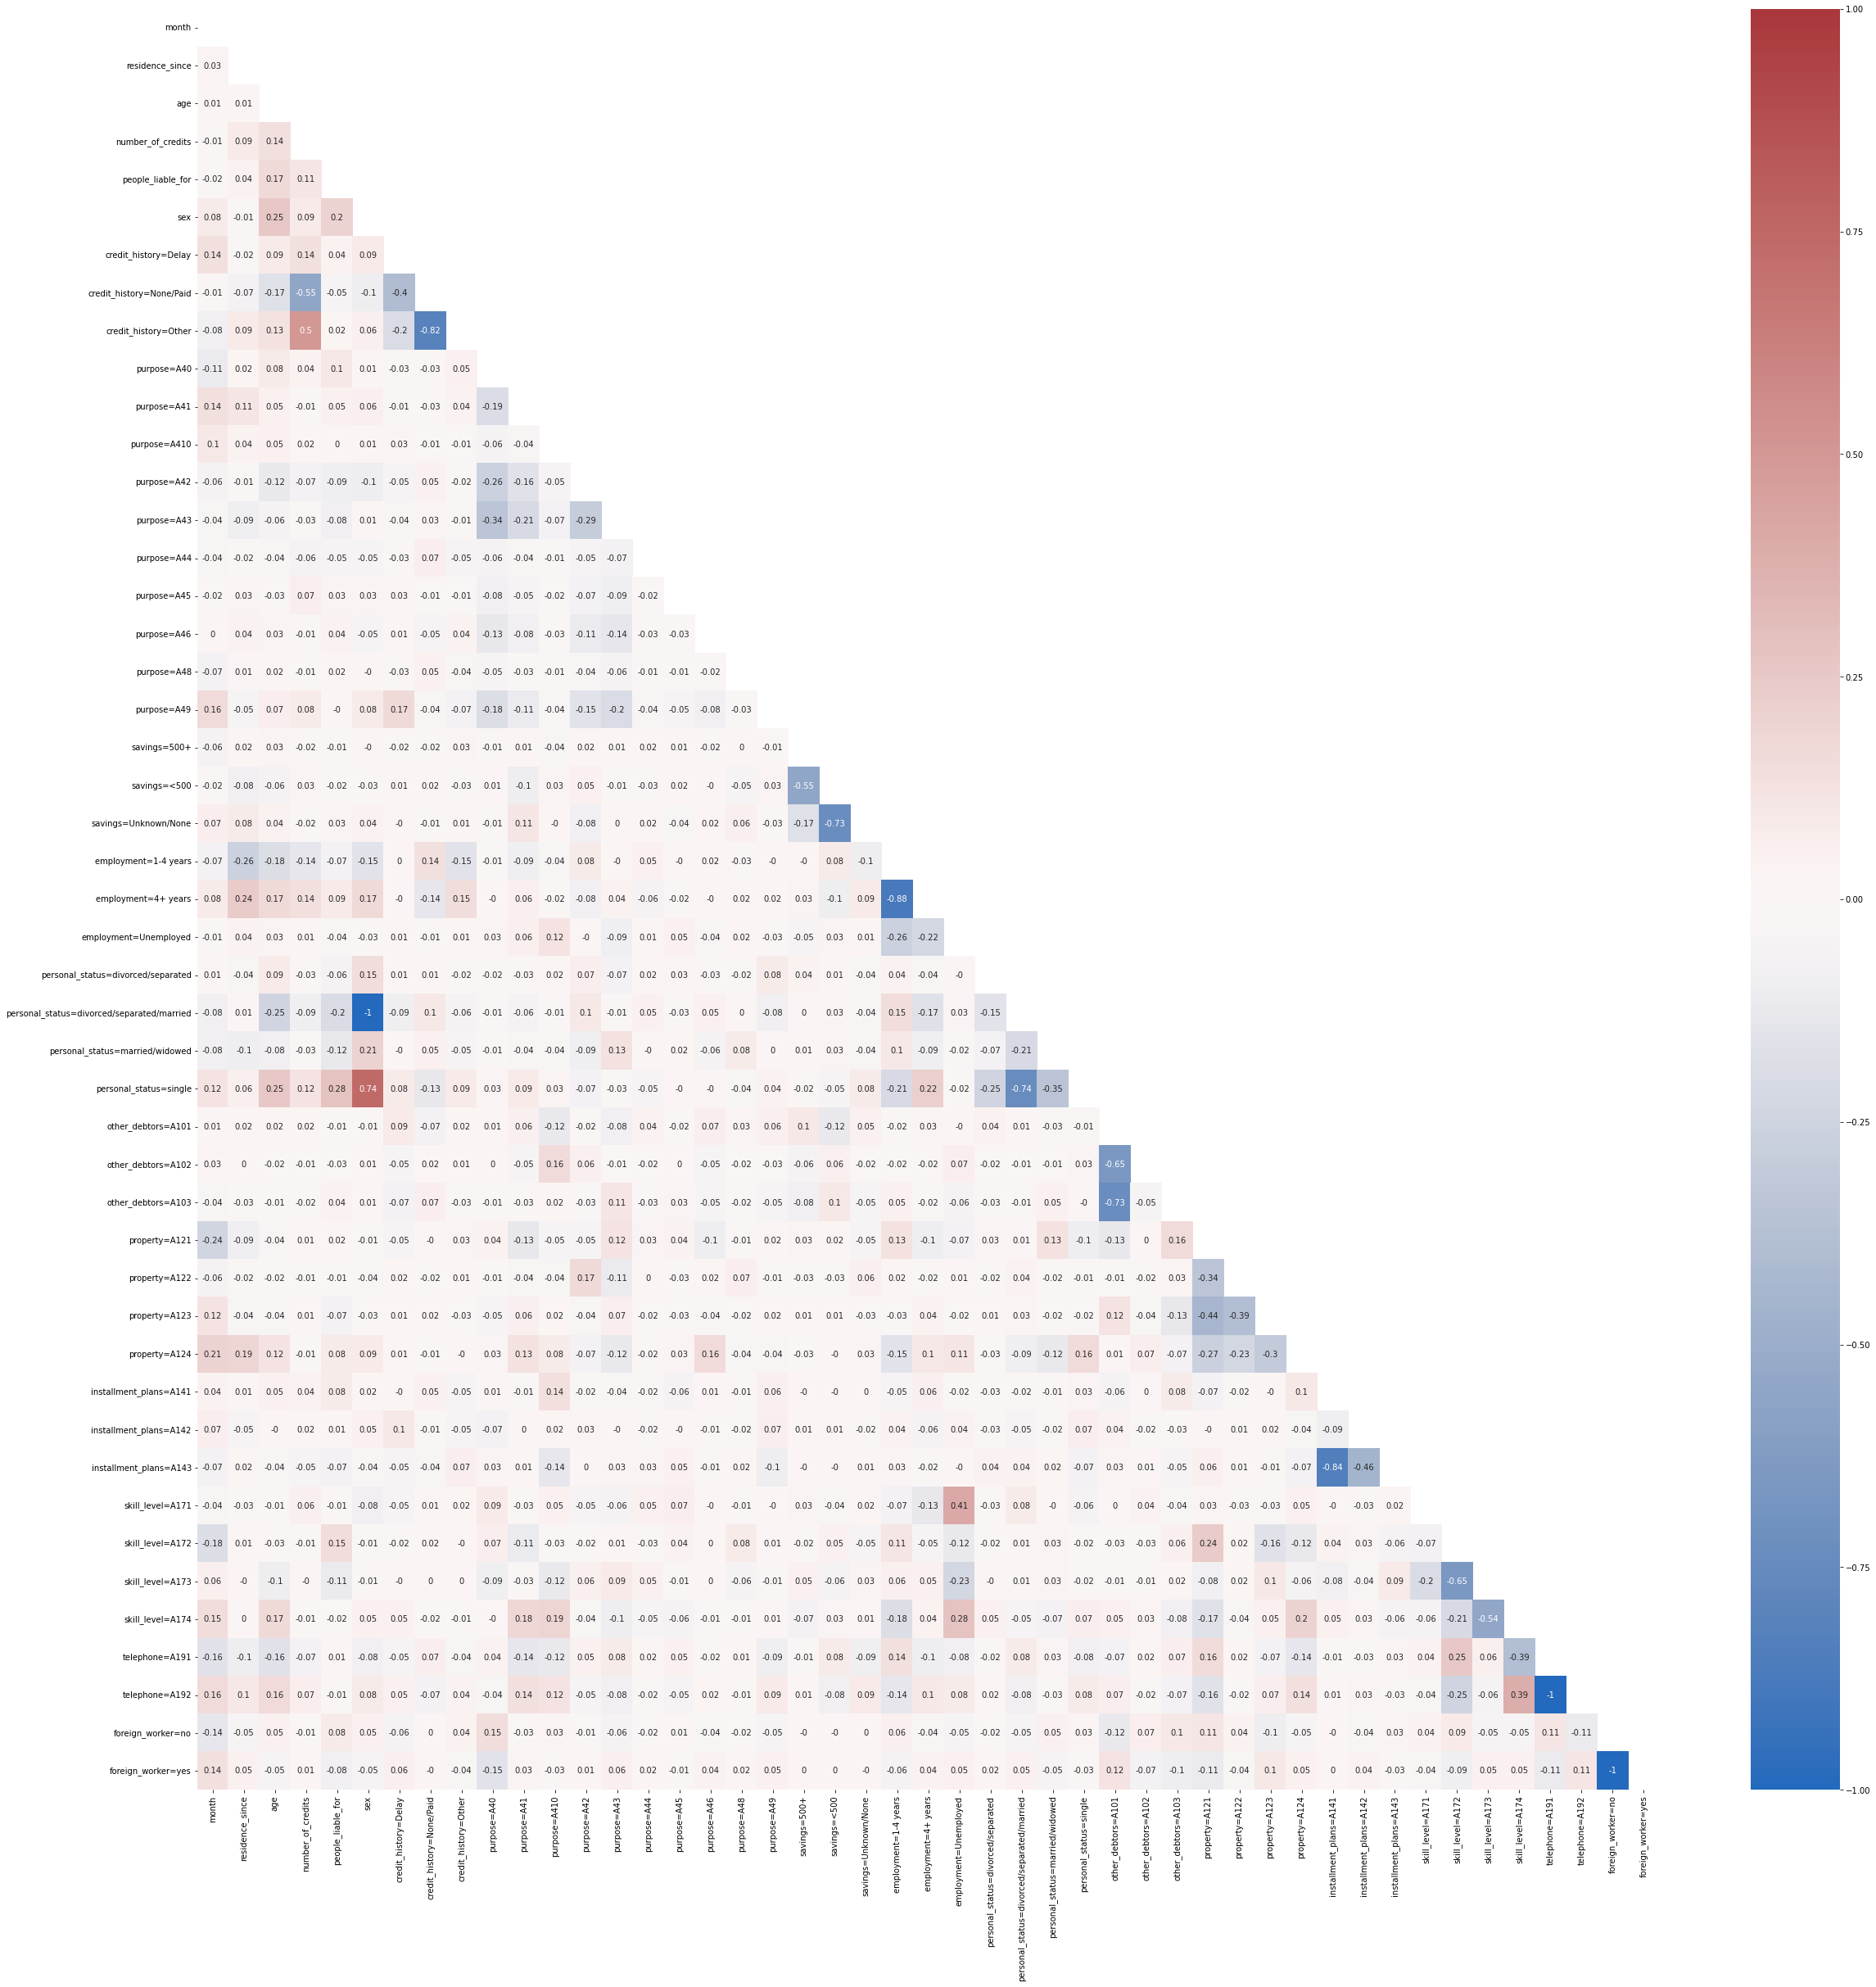

In [8]:
# Code to answer Q3 - a and b:

# you would usually do this but you have too many attributes ;)
df = sns.load_dataset('penguins')
corr_matrix = pd_gdata.corr().round(2)
# print(corr_matrix)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(40,40))       
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, ax=ax)
plt.show()

In [9]:
# Alternative code Q3 - a and b: 
# Display raked corrolation for sensitive attributes and proxies only
# Protected attribute:
protected_attributes_to_test = ["age", "sex", "foreign_worker=no", "foreign_worker=yes"]

correlation_dict = {}
for protected_attribute in protected_attributes_to_test:
    correlation_dict[protected_attribute] = []
    for feature in list(pd_gdata.columns):
        correlation_dict[protected_attribute].append((feature, pd_gdata[protected_attribute].corr(pd_gdata[feature])))
        
for protected_attribute in protected_attributes_to_test:
    print("Correlation with ", protected_attribute, ":")
    print(sorted(correlation_dict[protected_attribute], key=lambda x: abs(x[1]), reverse=True))


Correlation with  age :
[('age', 0.9999999999999999), ('sex', 0.25408335958468753), ('personal_status=divorced/separated/married', -0.25408335958468753), ('personal_status=single', 0.24646020881508962), ('employment=1-4 years', -0.17801871395214452), ('credit_history=None/Paid', -0.17001366349634087), ('skill_level=A174', 0.1659655176134102), ('employment=4+ years', 0.1655770600697827), ('people_liable_for', 0.16516930203795846), ('telephone=A191', -0.16498610560766783), ('telephone=A192', 0.16498610560766783), ('number_of_credits', 0.13832166368063867), ('credit_history=Other', 0.12696636706339023), ('property=A124', 0.12189220671999705), ('purpose=A42', -0.11658933031528917), ('skill_level=A173', -0.09661857836889812), ('personal_status=divorced/separated', 0.08771929824561389), ('credit_history=Delay', 0.08745974359057858), ('personal_status=married/widowed', -0.08396161826705482), ('purpose=A40', 0.07501988928610658), ('purpose=A49', 0.07260700495098622), ('purpose=A43', -0.0613139

<H3>Step 4: Representation Bias, Disparities and Skews.</H3>

<br>
<b>Q4: Representation biases: Representation Disparity</b>

a) Is the dataset we are working with representative of the German population with regard to age. Add any needed code or analysis to briefely justify your answer<br>
b) Is the dataset we are working with representative of the German population with regard to gender. Add any needed code or analysis to briefely justify your answer

<b>(Optional)</b><br>
c) Look at the joint distribution of the attributes for sex and personal_status=divorced/separated/married. Does the dataset seem to be representative of the German population?<br>
d) Similarly, look at the distribution of foreign workers. Does the dataset seem to be representative of the German population?<br>

<div class="alert alert-block alert-info">
<b> Tip: </b> You can find demographic information from Wikipedia <a href=https://en.wikipedia.org/wiki/Demographics_of_Germany>[Here]</a>
    
Go to section <b><i>Demographic statistics</i></b> take a closer look at the most racent  <b><i>Age structure</i></b> data (it should be from 2018). Use this data to build a distribution of german population across age, then across gender and compare it to the distributions from <b><i>the German credit data</i></b> we are working with.

It is up to you how you want to justify your answer, however using visualizations will provide more points (i.e., plots and diagram)
</div>
    

In [10]:
# write you code here 
# 


-

<div class="alert alert-block alert-success">
<b>Correct Answer:</b>

<u>Wikipedia Data from 2018</u><br>
0-14 years: 12.83% (male 5,299,798 /female 5,024,184)<br>
15-24 years: 9.98% (male 4,092,901 /female 3,933,997)<br>
25-54 years: 39.87% (male 16,181,931 /female 15,896,528)<br>
55-64 years: 14.96% (male 5,989,111 /female 6,047,449)<br>
65 years and over: 22.36% (male 7,930,590 /female 10,061,248)<br><br>

female population: 50.76% 
male population: 49.24%
    
<br>



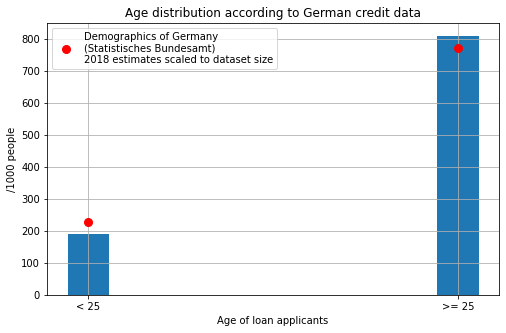

In [11]:
plt.figure(1, figsize=(8.1, 5))
pd_gdata['age'].hist();
plt.xticks(np.arange(0.05, 1, 0.9), labels=['< 25', '>= 25']);
plt.xlabel('Age of loan applicants');
plt.ylabel('/1000 people')
plt.title('Age distribution according to German credit data');
plt.plot([0.05, 0.95], [128.3 + 99.8 , 398.7 + 149.6 +223.6], 'o--', c='red', linewidth=0, markersize=8, label='Demographics of Germany\n(Statistisches Bundesamt)\n2018 estimates scaled to dataset size');
plt.legend();



   
<b>Q4 - a </b> From the plot, 19.9% of people are under 25 years old in Germany. German age statistics in wikipedia seem to much that population under 25 are around 22% or the population. is it that simple? what are we missing?
<br>

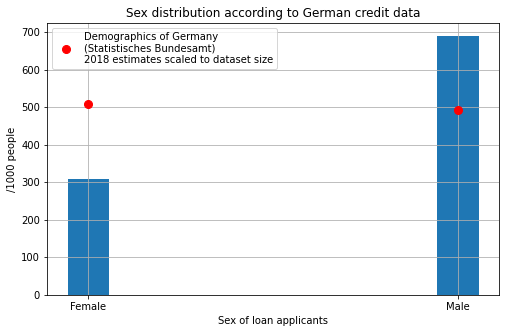

In [12]:
plt.figure(2, figsize=(8.1, 5))
pd_gdata['sex'].hist();
plt.xticks(np.arange(0.05, 1, 0.9), labels=['Female', 'Male']);
plt.xlabel('Sex of loan applicants');
plt.ylabel('/1000 people')
plt.title('Sex distribution according to German credit data');
plt.plot([0.05, 0.95], [507.6 , 492.4 ], 'o--', c='red', linewidth=0, markersize=8, label='Demographics of Germany\n(Statistisches Bundesamt)\n2018 estimates scaled to dataset size');
plt.legend();

<b>Q4 - b)</b>  From the statistics provided, we see there is an almost equal proportion of males and females in Germany, but an analysis of the dataset shows a skew towards males (70% samples in the dataset correspond to males).

<b>Q5: Representation Bias: Outcome Skews </b> 

Is there a skew towards certain groups:<br>
a) Analyse the dataset, and report the numbers of male / female with bad/good credit. Do the same for "old" / " young" people in the datset. Normalize these numbers respectively over the total number of males/females, "old"/"young" for a fair comparison. For that, you can consider having 50 individuals for each of these groups.

b) Brieflt describe your findings and explain the impacts (on faireness) of using this dataset as training data (if any)

<div class="alert alert-block alert-info">
<b> Tip: </b> We provide a function for Normalised count per attribut and lable you are free to use it or implement your own method 
    
`getNormalizedCount(pd_train_data, protected_attribute, label)`
</div>
    

In [13]:
# Normalised count per attribut and lable 
def getNormalizedCount(pd_train_data, protected_attribute, label):
    unnormalized_count = pd_train_data[[protected_attribute, label]].value_counts()
    counts = {}
    for attribute_value in pd_train_data[[protected_attribute]].value_counts().keys():
        counts[attribute_value[0]] = pd_train_data[[protected_attribute]].value_counts()[attribute_value]
    normalized_count = unnormalized_count[:]
    for attribute_value, credit_value in pd_train_data[[protected_attribute, label]].value_counts().keys():
        normalized_count[attribute_value, credit_value] = normalized_count[attribute_value, credit_value] * (50 / counts[attribute_value])
    return normalized_count

# add the credit labels to the data set.
pd_gdata["credit"] = dataset_gcredit.labels

In [14]:
### YOUR ANSWER HERE ###
# ADD code here to print the AGE-CREDIT distribution


# ADD code here to print the SEX-CREDIT distribution


# ADD code here to visualise the results for both you can use stacked bar plots from pandas toolkit
#<your dataframe>.size().unstack().plot(kind='bar', stacked=True)


-

<b>Correct Answer:</b>

<div class="alert alert-block alert-success">

    
<b>Q5 - a)</b> 

    age  credit

    1.0  1.0       36

         2.0       13
     
    0.0  1.0       28

         2.0       21

    sex  credit
    
    1.0  1.0       36
    0.0  1.0       32
    1.0  2.0       13
    0.0  2.0       17

For both protected attributes, the numbers are unequal. There is a certain bias.
Younger applicants tend to receive less positive outcomes than older ones. Male tend to receive more positive outcomes than females.

--------------

<b>Q5 - b)</b>  In the case where the real-world situation is considered fair, we might consider a classifier trained on this data fair. However, we would need to check whether its outputs indeed reflect these input distributions (this might not be the case when the classifier makes systematic mistakes, as Q5 showed inbalance, it might indeed make mistakes).

Often though, the real-world situation is considered unfair (e.g., credit ratings are given depending on some human biases) and hence datasets of historical decisions are unfair. A fair situation would often be if both the protected and unprotected groups have an equal likelihood of getting good/bad credit. Fot instance, there would be 21 good credits out of 50 for both "old" and "young" people. In such case, a classifier trained on the data we have here would not be considered fair.



</div>

In [15]:
### YOUR ANSWER HERE ###

# The German data set contains 700 instances of good credit, and 300 instances of bad credit. 
# The good credit has credit value 1, the bad credit has credit value 2

# The people over 25 are labeled age == 1, the people under 25 are labeled age == 0
# ADD code here to print the AGE-CREDIT distribution
protected_attribute = "age"
label = "credit"
agecredit = getNormalizedCount(pd_gdata, protected_attribute, label)


# The female entries are labeled sex == 0, the male entries are labeled sex == 1
# ADD code here to print the SEX-CREDIT distribution
protected_attribute = "sex"
# label = "credit" already initialized
sexcredit= getNormalizedCount(pd_gdata, protected_attribute, label)


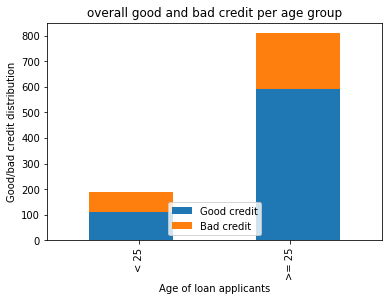

In [16]:

# Example of overall distrimution
#<your data>.size().unstack().plot(kind='bar', stacked=True)
pd_gdata.groupby([ "age", "credit"]).size().unstack().plot(kind='bar', stacked=True)
plt.title('overall good and bad credit per age group');
plt.xticks(np.arange(0.05, 1, 0.9), labels=['< 25', '>= 25']);
plt.xlabel('Age of loan applicants');
plt.ylabel('Good/bad credit distribution');
plt.legend(['Good credit', 'Bad credit'], loc='lower center');

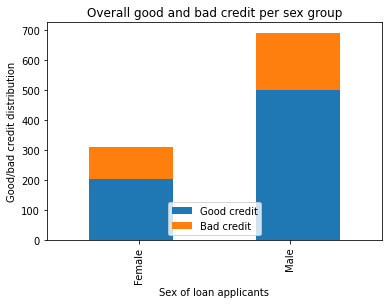

In [17]:
pd_gdata.groupby([ "sex", "credit"]).size().unstack().plot(kind='bar', stacked=True)

plt.title('Overall good and bad credit per sex group');
plt.xticks(np.arange(0.05, 1, 0.9), labels=['Female', 'Male']);
plt.xlabel('Sex of loan applicants');
plt.ylabel('Good/bad credit distribution');
plt.legend(['Good credit', 'Bad credit'], loc='lower center');


age  credit
1.0  1.0       36
     2.0       13
0.0  1.0       28
     2.0       21
dtype: int64


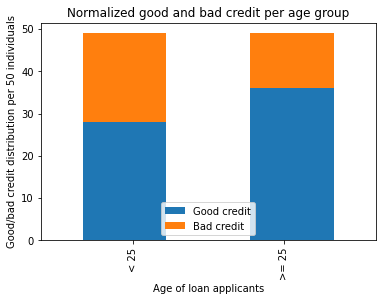

In [18]:
# Example of normalized distribution
# ADD code here to visualise the results for both you can use stacked bar plots from pandas toolkit

print(agecredit)
agecredit.unstack().plot.bar(stacked=True)
plt.title('Normalized good and bad credit per age group');
plt.xticks(np.arange(0.05, 1, 0.9), labels=['< 25', '>= 25']);
plt.xlabel('Age of loan applicants');
plt.ylabel('Good/bad credit distribution per 50 individuals');
plt.legend(['Good credit', 'Bad credit'], loc='lower center');


sex  credit
1.0  1.0       36
0.0  1.0       32
1.0  2.0       13
0.0  2.0       17
dtype: int64


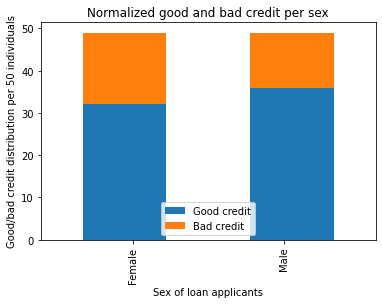

In [19]:
print(sexcredit)
sexcredit.unstack().plot.bar(stacked=True)
plt.title('Normalized good and bad credit per sex');
plt.xticks(np.arange(0.05, 1, 0.9), labels=['Female', 'Male']);
plt.xlabel('Sex of loan applicants');
plt.ylabel('Good/bad credit distribution per 50 individuals');
plt.legend(['Good credit', 'Bad credit'], loc='lower center');

<br><br>

# Part II. Observational Faireness Metrics.



Step 1: Re-process the data. <br>
Step 2: Building a Classifier. <br>
Step 3: Classification threshold and fairness constraint

<H3>Step 1: Re-process the data.<H3>

**Option 1: Re-process the data for age fairness**<br>
uncomment the following block to re-process the data and set age as a protected attribute

In [20]:
# def preproc_and_load_data_german():
#     """
#     Load and pre-process german credit dataset.
#     Args: -
#     Returns:
#         GermanDataset: An instance of GermanDataset with required pre-processing.
#     """
#     def custom_preprocessing(df):
#         """ Custom pre-processing for German Credit Data
#         """

#         def group_credit_hist(x):
#             if x in ['A30', 'A31', 'A32']:
#                 return 'None/Paid'
#             elif x == 'A33':
#                 return 'Delay'
#             elif x == 'A34':
#                 return 'Other'
#             else:
#                 return 'NA'

#         def group_employ(x):
#             if x == 'A71':
#                 return 'Unemployed'
#             elif x in ['A72', 'A73']:
#                 return '1-4 years'
#             elif x in ['A74', 'A75']:
#                 return '4+ years'
#             else:
#                 return 'NA'

#         def group_savings(x):
#             if x in ['A61', 'A62']:
#                 return '<500'
#             elif x in ['A63', 'A64']:
#                 return '500+'
#             elif x == 'A65':
#                 return 'Unknown/None'
#             else:
#                 return 'NA'

#         def group_status(x):
#             if x in ['A11', 'A12']:
#                 return '<200'
#             elif x in ['A13']:
#                 return '200+'
#             elif x == 'A14':
#                 return 'None'
#             else:
#                 return 'NA'
        
#         def group_personal_status(x):
#             if x in ['A91']:
#                 return 'divorced/separated'
#             elif x in ['A92']:
#                 return 'divorced/separated/married'
#             elif x in ['A93', 'A95']:
#                 return 'single'
#             elif x in ['A94']:
#                 return 'married/widowed'
#             else:
#                 return 'NA'

#         def group_foreign_worker(x):
#             if x in ['A201']:
#                 return 'yes'
#             elif x in ['A202']:
#                 return 'no'
#             else:
#                 return 'NA'

#         #print(df)
#         #print(df.shape)
#         #print(df.isnull().sum().sum())
#         #print(df.isin(['NA']).sum(axis=0))
#         status_map = {'A91': 1.0, 'A93': 1.0, 'A94': 1.0,
#                     'A92': 0.0, 'A95': 0.0}
        
#         df['sex'] = df['personal_status'].replace(status_map)
        

#         # group credit history, savings, and employment
#         df['credit_history'] = df['credit_history'].apply(lambda x: group_credit_hist(x))
#         df['savings'] = df['savings'].apply(lambda x: group_savings(x))
#         df['employment'] = df['employment'].apply(lambda x: group_employ(x))
#         #df['age'] = df['age'].apply(lambda x: np.float(x >= 26))
#         df['status'] = df['status'].apply(lambda x: group_status(x))
#         df['personal_status'] = df['personal_status'].apply(lambda x: group_personal_status(x))
#         df['foreign_worker'] = df['foreign_worker'].apply(lambda x: group_foreign_worker(x))
#         group_foreign_worker
#         #print(df.isin(['NA']).sum(axis=0))
        
#         # print(df)
#         # uncomment if you want to save a version of the processed data
#         #df.to_csv("german_credit_data_processed.csv")
#         return df

#     # Feature partitions
#     XD_features = ['number_of_credits', 'telephone',
#                      'foreign_worker', 'people_liable_for', 'skill_level', 'credit_history',\
#                    'installment_plans', 'residence_since', 'property', 'other_debtors', \
#                    'purpose', 'savings', 'employment', 'sex', 'age', 'month']
#     D_features = ['age'] 
#     Y_features = ['credit']
#     X_features = list(set(XD_features)-set(D_features))
#     categorical_features = ['installment_plans', 'telephone',
#                      'foreign_worker', 'skill_level', 'credit_history', 'property',\
#                             'other_debtors', 'purpose', 'savings', 'employment']

#     # privileged classes
#     all_privileged_classes = {"age": lambda x: x > 25}

#     # protected attribute maps
#     all_protected_attribute_maps = {"age": {1.0: 'Old', 0.0: 'Young'}}

#     return GermanDataset(
#         label_name=Y_features[0],
#         favorable_classes=[1],
#         protected_attribute_names=D_features,
#         privileged_classes=[all_privileged_classes[x] for x in D_features],
#         instance_weights_name=None,
#         categorical_features=categorical_features,
#         features_to_keep=X_features+Y_features+D_features,
#         features_to_drop=["sex", "personal_status=divorced/separated/married"],
#         metadata={ 'label_maps': [{1.0: 'Good Credit', 2.0: 'Bad Credit'}],
#                    'protected_attribute_maps': [all_protected_attribute_maps[x]
#                                 for x in D_features]},
#         custom_preprocessing=custom_preprocessing)



In [21]:
# dataset_orig = preproc_and_load_data_german()

<b>Q6: Option 1</b>

a) Set the privilege and unprivilaged age group based on the findings of question Q5-a (answer in the text then add the variables 0 or 1 to the code below). Provide a very brief justification for your answer

<div class="alert alert-block alert-success">
<b>Correct Answer:</b>
- privileged category are age above 25 (code 1)
- unprivileged category are age below 25 (code 0). In the baking system and the Geman context Yonger pepole are more at risk of being descriminated against. 
    

In [22]:
# Add the code for question a) here
# code = 1: is old above 25
# code = 0: is young under 25

# # Correct Answer
# privileged_code = 1
# unprivileged_code = 0

In [23]:
# # We start by defining the privilaged and unprivileged 
# privileged_groups = [{'age': privileged_code}] 
# unprivileged_groups = [{'age': unprivileged_code}] 

**Option 2: Re-process the data for gender fairness**<br>
uncomment the following block to re-process the data and set sex as a protected attribute

In [24]:
def preproc_and_load_data_german():
    """
    Load and pre-process german credit dataset.
    Args: -
    Returns:
        GermanDataset: An instance of GermanDataset with required pre-processing.
    """
    def custom_preprocessing(df):
        """ Custom pre-processing for German Credit Data
        """

        def group_credit_hist(x):
            if x in ['A30', 'A31', 'A32']:
                return 'None/Paid'
            elif x == 'A33':
                return 'Delay'
            elif x == 'A34':
                return 'Other'
            else:
                return 'NA'

        def group_employ(x):
            if x == 'A71':
                return 'Unemployed'
            elif x in ['A72', 'A73']:
                return '1-4 years'
            elif x in ['A74', 'A75']:
                return '4+ years'
            else:
                return 'NA'

        def group_savings(x):
            if x in ['A61', 'A62']:
                return '<500'
            elif x in ['A63', 'A64']:
                return '500+'
            elif x == 'A65':
                return 'Unknown/None'
            else:
                return 'NA'

        def group_status(x):
            if x in ['A11', 'A12']:
                return '<200'
            elif x in ['A13']:
                return '200+'
            elif x == 'A14':
                return 'None'
            else:
                return 'NA'
        
        def group_personal_status(x):
            if x in ['A91']:
                return 'divorced/separated'
            elif x in ['A92']:
                return 'divorced/separated/married'
            elif x in ['A93', 'A95']:
                return 'single'
            elif x in ['A94']:
                return 'married/widowed'
            else:
                return 'NA'

        status_map = {'A91': 1.0, 'A93': 1.0, 'A94': 1.0,
                    'A92': 0.0, 'A95': 0.0}
        
        df['sex'] = df['personal_status'].replace(status_map)
        

        # group credit history, savings, and employment
        df['credit_history'] = df['credit_history'].apply(lambda x: group_credit_hist(x))
        df['savings'] = df['savings'].apply(lambda x: group_savings(x))
        df['employment'] = df['employment'].apply(lambda x: group_employ(x))
        #df['age'] = df['age'].apply(lambda x: np.float(x >= 26))
        df['status'] = df['status'].apply(lambda x: group_status(x))
        df['personal_status'] = df['personal_status'].apply(lambda x: group_personal_status(x))
        
        return df

    # Feature partitions
    XD_features = ['number_of_credits', 'telephone',
                     'foreign_worker', 'people_liable_for', 'skill_level', 'credit_history',\
                   'installment_plans', 'residence_since', 'property', 'other_debtors', \
                   'purpose', 'savings', 'employment', 'sex', 'age', 'month']
    D_features = ['sex'] 
    Y_features = ['credit']
    X_features = list(set(XD_features)-set(D_features))
    categorical_features = ['installment_plans', 'telephone',
                     'foreign_worker', 'skill_level', 'credit_history', 'property',\
                            'other_debtors', 'purpose', 'savings', 'employment']

    # privileged classes
    all_privileged_classes = {"sex": [1.0]}

    # protected attribute maps
    all_protected_attribute_maps = {"sex": {1.0: 'Male', 0.0: 'Female'}}

    return GermanDataset(
        label_name=Y_features[0],
        favorable_classes=[1],
        protected_attribute_names=D_features,
        privileged_classes=[all_privileged_classes[x] for x in D_features],
        instance_weights_name=None,
        categorical_features=categorical_features,
        features_to_keep=X_features+Y_features+D_features,
        features_to_drop=[],
        metadata={ 'label_maps': [{1.0: 'Good Credit', 2.0: 'Bad Credit'}],
                   'protected_attribute_maps': [all_protected_attribute_maps[x]
                                for x in D_features]},
        custom_preprocessing=custom_preprocessing)



In [25]:
dataset_orig = preproc_and_load_data_german()

<b>Q6: Option 2</b>

a) Set the privilege and unprivilaged age group based on the findings of question Q5-a (answer in the text then add the variables 0 or 1 to the code below). Provide a very brief justification for your answer


-

In [26]:
# Add the code for question a) here
# code = 1: male
# code = 0: female

#privileged_code = #add the write code here
#unprivileged_code = #add the write code here

In [27]:
# # Correct Answer
privileged_code = 1
unprivileged_code = 0

In [28]:
# # We start by defining the privilaged and unprivileged 
privileged_groups = [{'sex': privileged_code}]
unprivileged_groups = [{'sex': unprivileged_code}]

#### Preparation for training a classifier.
As we will learn a classifier, we need to divide the data into a training, validation and test sets.
We define them to use respectively 60%, 20% and 20% of the whole data.
We will use the following code to do so.

In [29]:
dataset_orig_train, dataset_orig_val, dataset_orig_test = \
    dataset_orig.split([0.6, 0.8], shuffle=True, seed=1)

#### Training a classifier.
As we want to automate the decision process, we need to learn a classifier. We make the choice of using a logistic regression classifier, that we train with the following code.

In [30]:
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset_orig_train.instance_weights}

lr_orig = model.fit(dataset_orig_train.features, dataset_orig_train.labels.ravel(), **fit_params)

#### Q7: Decision threshold and accuracy
#### *Determine the decision threshold to use for this logistic regression classifier, explain your method and report the threshold. Then, report the test accuracy and this average score for the test set for this threshold.* 
*Hint: Because this dataset might be class imbalanced, instead of using the accuracy, you should use the average of the true positive and true negative ratios.*

*Hint: We provide you with the "test()" function in order to compute various metrics on a dataset, for different thresholds. You can instantiate these thresholds with "thresh_arr = np.linspace(0.01, 0.99, 100)".*

In [31]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    dataset_pred = dataset.copy(deepcopy=True)
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    dataset_pred.scores = model.predict_proba(dataset_pred.features)[:,pos_ind].reshape(-1,1)
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        fav_inds = dataset_pred.scores > thresh
        dataset_pred.labels[fav_inds] = dataset_pred.favorable_label
        dataset_pred.labels[~fav_inds] = dataset_pred.unfavorable_label

        # Computation of various metrics:
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
        metric_arrs['acc'].append(metric.accuracy())
        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
        metric_arrs['precision_prot'].append(metric.precision(False))
        metric_arrs['precision_unprot'].append(metric.precision(True))
        metric_arrs['recall_prot'].append(metric.recall(False))
        metric_arrs['recall_unprot'].append(metric.recall(True))
        metric_arrs['num_TP'].append(metric.num_true_positives())
        metric_arrs['num_FP'].append(metric.num_false_positives())
        metric_arrs['num_TN'].append(metric.num_true_negatives())
        metric_arrs['num_FN'].append(metric.num_false_negatives())
        metric_arrs['positive_predictive_value_prot'].append(metric.positive_predictive_value(False))
        metric_arrs['positive_predictive_value_unprot'].append(metric.positive_predictive_value(True))
        metric_arrs['negative_predictive_value_prot'].append(metric.negative_predictive_value(False))
        metric_arrs['negative_predictive_value_unprot'].append(metric.negative_predictive_value(True))
        metric_arrs['false_negative_rate_difference'].append(metric.false_negative_rate_difference())
        metric_arrs['false_positive_rate_difference'].append(metric.false_positive_rate_difference())
        metric_arrs['disparate_impact'].append(metric.disparate_impact())
        metric_arrs['statistical_parity_difference'].append(metric.statistical_parity_difference())
        
        metric_arrs['proba_positive_prot'].append(metric.num_pred_positives(True)/metric.num_instances(True))
        metric_arrs['proba_positive_unprot'].append(metric.num_pred_positives(False)/metric.num_instances(False))

        metric_arrs['manual_statistical_parity_difference'].append(metric.num_pred_positives(False)/metric.num_instances(False)-metric.num_pred_positives(True)/metric.num_instances(True))
        metric_arrs['manual_disparate_impact'].append((metric.num_pred_positives(False)/metric.num_instances(False)) / (metric.num_pred_positives(True)/metric.num_instances(True)))
    return metric_arrs

thresh_arr = np.linspace(0.01, 0.99, 100)

In [32]:
# Answer Code for Q7:

val_metrics = test(dataset=dataset_orig_val,
                   model=lr_orig,
                   thresh_arr=thresh_arr)
print("Validation scores:")
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])
print("Optimal classification threshold = %.4f" % np.linspace(0.01, 0.99, 100)[lr_orig_best_ind])
print("Best balanced accuracy = %.4f" % np.max(val_metrics['bal_acc']))
print("Best accuracy = %.4f" % (val_metrics['acc'][lr_orig_best_ind]))


# Apply metrics to the test set.
#print("Classification threshold used = %.4f" % lr_orig_best_ind)   
test_metric = test(dataset_orig_test, model, thresh_arr)
print("Test scores:")
print("Balanced accuracy = %.4f" % (test_metric['bal_acc'][lr_orig_best_ind]))
print("Accuracy = %.4f" % (test_metric['acc'][lr_orig_best_ind]))

/usr/local/lib/python3.8/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
<ipython-input-31-dd6df636c141>:48: RuntimeWarning: divide by zero encountered in double_scalars
  metric_arrs['manual_disparate_impact'].append((metric.num_pred_positives(False)/metric.num_instances(False)) / (metric.num_pred_positives(True)/metric.num_instances(True)))


Validation scores:
Optimal classification threshold = 0.6534
Best balanced accuracy = 0.7086
Best accuracy = 0.7300
Test scores:
Balanced accuracy = 0.7165
Accuracy = 0.7350


#### Q8: *Confusion matrix*
The confusion matrix for this problem looks like the following:

    repay        | TP                     | FN

    did not repay | FP                     | TN

                  | good credit (low risk) | bad credit (high risk)
                      
#### *a) Give the number of true positive (TP), true negative (TN), false positive (FP) and false negative (FN) for the test set and a threshold of  0.68. Hint: you can use the AIF360 ClassificationMetric class to get these numbers, or make use of certain outputs of the "test()" function.*


**Optional**
Different stakeholders related to the system might want to check that different scores hold, and these scores can be expressed with the numbers in the confusion matrix. That is what we study in the following questions.

#### *b) The bank which gives loan might want to check the likelihood for those who are classified as good credit by the system (i.e. those who will be granted a loan), how many will indeed repay. How would you express this ratio in terms of TP, FP, FN, TN? Compute it.*

#### *c) The bank might also want to know out of those labeled bad credit, how many would actually repay. How would you express this ratio in terms of TP, FP, FN, TN? Compute it.*

#### *d) A bank client would like to know the probability that he/she would be incorrectly classified high risk while they are not. How would you express this ratio in terms of TP, FP, FN, TN? Compute it.*

#### *e) A classifier is often evaluated in terms of precision and recall. Compute the two scores. Reminder: precision is expressed in terms of TP / (TP + FP), recall is expressed in terms of TP / (TP + FN). To what extent are these scores satisfying?*

### Q9: Fairness metrics

In Q8, we evaluated the classifer as it is usually done in machine learning. It appears more or less satisfying depending on the metric. But what happens if we now evaluate the classifier separately for the protected and non-protected groups? Reminder: In all the following questions, the protected group will be female, and the non-protected group male.

Most group fairness metrics consist in (1) computing one or several of these scores  (and their average) separately for the protected and non protected groups, and then (2) computing the difference or ratio of these scores. In this paper, you can find a summary of the main fairness metrics that exist https://fairware.cs.umass.edu/papers/Verma.pdf.

We now take a look at some of these metrics. Hint: for these questions, you can either again make use of the outputs of the "test()" function, or draw the confusion matrices for the two groups separately and compute them manually.

#### *a) We are interested in the positive predictive value ( TP / (TP + FP)). Compute the difference between the one for the protected group and non-protected group. Provide an interpretation of this metric.*

#### *b) We are interested in the negative predictive value ( FN / (FN + TN)). Compute the difference between the one for the protected group and non-protected group. Provide an interpretation of this metric.*

#### *c) We are interested in one of the error rate balance measures, relying on false negatives ( FN / (TP + FN)). Compute the difference between the one for the protected group and non-protected group. Provide an interpretation of this metric.*

#### *d) We are interested in one of the error rate balance measures, relying on false positives ( FP / (TN + FP)). Compute the difference between the one for the protected group and non-protected group. Provide an interpretation of this metric, especially in comparison with the metric in c).*

Disparate impact and statistical parity difference are two other very connected fairness metrics, relying on the probabilities of getting a positive outcome (i.e. getting a good credit label in our scenario) for the protected and non-protected groups. Disparate impact is computed by calculating the ratio of these two numbers, while statistical parity difference consists in computing their difference.
#### *e) Provide the measure for these two scores, explain how they relate to the confusion matrix (how are they computed) and explain how you would interpret them, especially in which cases someone might choose to focus on these metrics.*

#### *f) Looking at this new information compared to Q8, would you use the classifier in practice? why?*

In [33]:
# Code for Q8 a):
test_metric = test(dataset_orig_test, model, [0.68])
print("TP: ", test_metric["num_TP"][0])
print("TN: ", test_metric["num_TN"][0])
print("FP: ", test_metric["num_FP"][0])
print("FN: ", test_metric["num_FN"][0])

TP:  99.0
TN:  46.0
FP:  17.0
FN:  38.0


### Q9: Fairness metrics

In Q8, we evaluated the classifer as it is usually done in machine learning. It appears more or less satisfying depending on the metric. But what happens if we now evaluate the classifier separately for the protected and non-protected groups? Reminder: In all the following questions, the protected group will be female, and the non-protected group male.

Most group fairness metrics consist in (1) computing one or several of these scores  (and their average) separately for the protected and non protected groups, and then (2) computing the difference or ratio of these scores. In this paper, you can find a summary of the main fairness metrics that exist https://fairware.cs.umass.edu/papers/Verma.pdf.

We now take a look at some of these metrics. Hint: for these questions, you can either again make use of the outputs of the "test()" function, or draw the confusion matrices for the two groups separately and compute them manually.

#### *a) We are interested in the positive predictive value ( TP / (TP + FP)). Compute the difference between the one for the protected group and non-protected group. Provide an interpretation of this metric.*

#### *b) We are interested in the negative predictive value ( FN / (FN + TN)). Compute the difference between the one for the protected group and non-protected group. Provide an interpretation of this metric.*

#### *c) We are interested in one of the error rate balance measures, relying on false negatives ( FN / (TP + FN)). Compute the difference between the one for the protected group and non-protected group. Provide an interpretation of this metric.*

#### *d) We are interested in one of the error rate balance measures, relying on false positives ( FP / (TN + FP)). Compute the difference between the one for the protected group and non-protected group. Provide an interpretation of this metric, especially in comparison with the metric in c).*

Disparate impact and statistical parity difference are two other very connected fairness metrics, relying on the probabilities of getting a positive outcome (i.e. getting a good credit label in our scenario) for the protected and non-protected groups. Disparate impact is computed by calculating the ratio of these two numbers, while statistical parity difference consists in computing their difference.
#### *e) Provide the measure for these two scores, explain how they relate to the confusion matrix (how are they computed) and explain how you would interpret them, especially in which cases someone might choose to focus on these metrics.*

#### *f) Looking at this new information compared to Q8, would you use the classifier in practice? why?*

In [34]:

# Q9 Answer code

#a)
print("Positive predictive value difference: ", test_metric['positive_predictive_value_prot'][0] - test_metric['positive_predictive_value_unprot'][0])

#b)
print("Negative predictive value difference: ", test_metric['negative_predictive_value_prot'][0] - test_metric['negative_predictive_value_unprot'][0])

#c)
print("False negative rate difference: ", test_metric['false_negative_rate_difference'][0])

#d)
print("False positive rate difference: ", test_metric['false_positive_rate_difference'][0])

#e)
print("Disparate impact: ", test_metric['disparate_impact'][0],\
      ', manual computation: ', test_metric['manual_disparate_impact'][0])
print("Statistical parity difference: ", test_metric['statistical_parity_difference'][0],\
      ', manual computation: ', test_metric['manual_statistical_parity_difference'][0])

#print(test_metric['precision_prot'], test_metric['precision_unprot'], test_metric['recall_prot'], test_metric['recall_unprot'])

Positive predictive value difference:  0.09902597402597402
Negative predictive value difference:  0.06823529411764706
False negative rate difference:  0.10257731958762883
False positive rate difference:  -0.2749445676274944
Disparate impact:  0.7082111436950147 , manual computation:  0.7082111436950147
Statistical parity difference:  -0.18606825619448336 , manual computation:  -0.18606825619448336


Further comments Q9
    
a) positive predictive value maximizes low risk loans (same as bank stakeholder case 1). So the difference allows to understand whether generally one population will be said to reimburse more often and hence will be given more loans.

b) negative predictive value represents the probability for a bank to miss on persons who would actually reimburse (same as bank stakeholder case 2). So the difference shows whether the bank misses out more on one population than the other.

c) false negative rate represents the likelihood for someone to be missclassified as high risk. The difference shows whether some populations are more often missclassifed negstively than others.

d) false positive rate represents the likelihood for someone to be missclassified as low risk. The difference shows whether one population is more often given loans whereas they have high risk (it is also not beneficial for this population).

e) The last two scores compare the likelihood for the two groups to get predicted as low risk. This might be what a "society" proposes in general to equalize the opportunities of different demographics. The scores to compare are computed by (TP + FP) / (TP + FP + FN + TN).

f) It's an open question. But they should mention that we now observe differences that we might or not want to accept... How to choose which metrics are the most important - they can mention this is a difficult question, that it might not be the data scuientist who wants to make this implicit decision alone (Transparency is needed).

<H3>Step 3: Classification threshold and fairness constraint</H3>
The choice of decision threshold does not only impact measures of accuracy, but can also impact the fairness of the classifier. That is what we study here.

#### Q10: Disparate impact
Ideally, the disparate impact is equal to 1, and it can take values above and under 1. The value is lower than 1 when it advantages the non protected group, and above 1 when it advantages the protected one. Because of that, we can not directly compare it to a measure of accuracy since their interpretation is different (the ranges are different). 
Hence a more easily interpretable measure of unfairness would be the distance of the score to 1. 
However, due to the nature of this ratio of probabilities, values above 1 are not directly comparable to the values under 1 - values above 1 "overcorrect" the ratio (the two groups would not be treated similarly). For that reason, we don't directly study the disparate impact but 1−min(disparate impact,1/disparate impact) to correct this issue.

<i>Disparet impact simplified formula</i><br>

𝑃𝑟(𝑌̂ =pos_label|𝐷=unprivileged)/𝑃𝑟(𝑌̂ =pos_label|𝐷=privileged)<br>

#### *a) We plot for the validation dataset  1−min(disparate impact,1/disparate impact) and the balanced accuracy for thresholds between 0.01 and 0.99. Where would you set a threshold in relation to this new metric?  (you don't need to report a very specific threshold but simply give an approximate number) Explain your reasoning.*

#### *b) Recall the threshold you had set earlier. Do these thresholds match? Reflect on that.*

#### *c) Append to this plot the two curves for the two scores that compose the ratio in the calculation of the disparate impact. <br> Hint: you can find these scores in the outputs of the test() function.*

#### *Assuming we want a balanced accuracy above 0.65, where would you set thresholds observing these metrics (you don't need to report very specific thresholds but simply give  approximate numbers)? Explain your reasoning. <br>Hint: you might want to set different thresholds in the case where you maximize each of the two metric, and in the case where you focus on disparate impact.*

#### *d) Do the thresholds match for the different cases in c)? Reflect on that.*

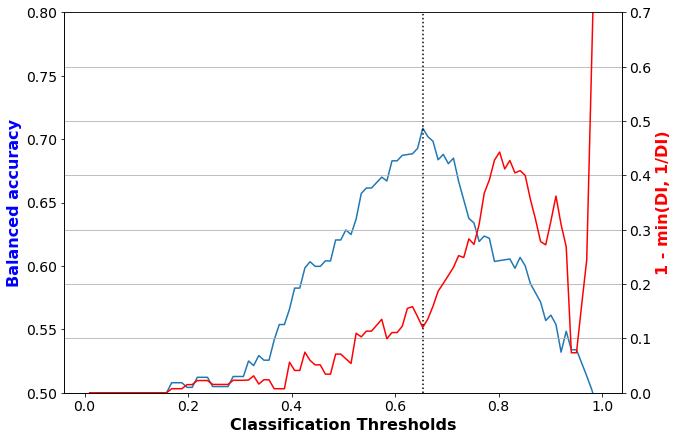

In [35]:
# Code for a
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name, best_treshold=None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)
    if "difference" in y_left_name:
        ax1.set_ylim(-0.5, 0.5)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)
    
    if best_treshold:
        best_ind = best_threshold
    else:
        best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

a) We need to set a threshold to lower the disparate impact while keeping Balanced Accuracy with the desired range

b) This threshold does not match with the threshold set for the balanced accuracy. A first trade-off appear here! Deciding on a threshold forces to make a choice on the metric to priviledge (accuracy or disparate impact here).

-

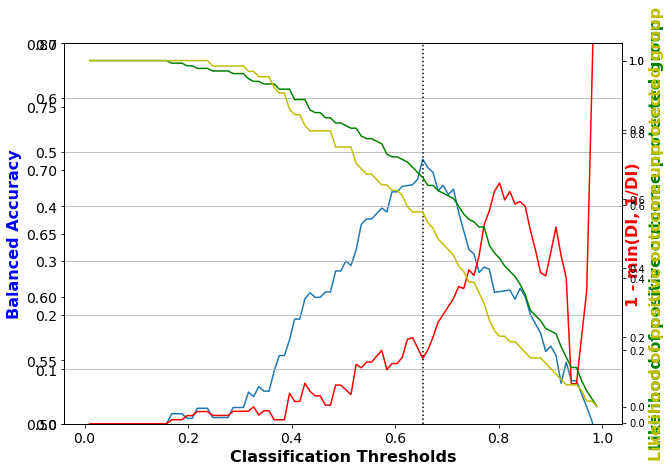

In [37]:
# code for A11c

def plot2(x, x_name, y_1, y_1_name, y_2, y_2_name=None, y_3=None, y_3_name=None, y_4=None, y_4_name=None, best_treshold=None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_1)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_1_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_2, color='r')
    ax2.set_ylabel(y_2_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_2_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)
    
    if best_treshold:
        best_ind = best_threshold
    else:
        best_ind = np.argmax(y_1)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    
    ax3 = ax2.twinx()
    ax3.plot(x, y_3, color='g')
    ax3.set_ylabel(y_3_name, color='g', fontsize=16, fontweight='bold')
    
    ax4 = ax2.twinx()
    ax4.plot(x, y_4, color='y')
    ax4.set_ylabel(y_4_name, color='y', fontsize=16, fontweight='bold')
    
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
proba_positive_prot = (val_metrics['proba_positive_prot'])
proba_positive_unprot = (val_metrics['proba_positive_unprot'])

plot2(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)',
     proba_positive_prot, "Likelihood of positive outcome protected group",
     proba_positive_unprot, "Likelihood of positive outcome unprotected group")

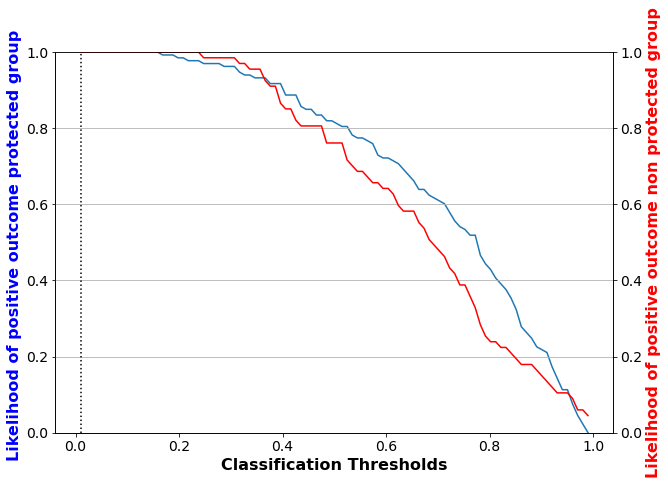

In [38]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name, best_treshold=None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.0, 1)
    if "difference" in y_left_name:
        ax1.set_ylim(-0.5, 0.5)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(0.0, 1)
    
    if best_treshold:
        best_ind = best_threshold
    else:
        best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    
proba_positive_prot = (val_metrics['proba_positive_prot'])
proba_positive_unprot = (val_metrics['proba_positive_unprot'])
plot(thresh_arr, 'Classification Thresholds',
     proba_positive_prot, "Likelihood of positive outcome protected group ",
     proba_positive_unprot, "Likelihood of positive outcome non protected group")

<H3>To Go further: Existing tools and Metrics</H3>

**FairLearning Framwork**<br>
Provides a ritch Observational Fairness Library of Metrics and Mitigation Approaches.<br>
Provides many tools to measure, mitigate bias and to explain ML outputs
For more information check the website and tutorials of <a href=https://fairlearn.org/><b>FairLearning</b></a>.
<br><br>

**IBM AI Fairness 360** <br>
Provides many tools to measure, mitigate bias and to explain ML outputs.<br>
For more information make use of the documentation of <a href=https://aif360.readthedocs.io/en/latest/index.html><b>AIF360</b></a>.

<br><br>